In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model

In [3]:
train_classes_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_classes_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

40479


In [5]:
sample_submission_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [6]:
test1 = !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l
test2 = !ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l
assert sample_submission_df.shape[0] == float(test1[0])+float(test2[0])

In [7]:
test2

['20522']

In [8]:
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
image_number =10
img = io.imread('../input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(image_number))

In [10]:
img.shape

(256, 256, 3)

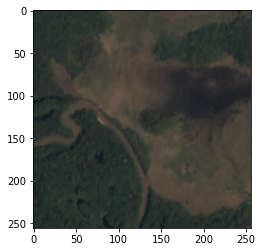

In [11]:
plt.imshow(img)

In [12]:
train_classes_df[train_classes_df['image_name'] == 'train_10']

,image_name,tags
10,train_10,agriculture clear primary slash_burn water


In [13]:
train_classes_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [14]:
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train_classes = train_classes_df.copy()
train_classes['tags'].apply(append_labels)
unique_labels = list(unique_labels)
print(unique_labels)

['conventional_mine', 'habitation', 'partly_cloudy', 'clear', 'slash_burn', 'cloudy', 'haze', 'blow_down', 'road', 'agriculture', 'selective_logging', 'bare_ground', 'cultivation', 'primary', 'artisinal_mine', 'water', 'blooming']


In [15]:
len(unique_labels)

17

In [16]:
assert len(train_classes['image_name'].unique()) == train_classes.shape[0]

In [17]:
# let's do one hot encoding (vectorize) the labels in 'train_classes'
for tag in unique_labels:
    train_classes[tag] = train_classes['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
train_classes['image_name'] = train_classes['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_classes.head()

,image_name,tags,conventional_mine,habitation,partly_cloudy,clear,slash_burn,cloudy,haze,blow_down,road,agriculture,selective_logging,bare_ground,cultivation,primary,artisinal_mine,water,blooming
0,train_0.jpg,haze primary,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
2,train_2.jpg,clear primary,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,train_3.jpg,clear primary,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0


In [18]:
import tensorflow as tf

In [19]:
y_col = list(train_classes.columns[2:]) # storing the tags column names as a variable

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# loading images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(64, 64), class_mode='raw', seed=1, batch_size=64)

Found 40479 validated image filenames.


In [20]:
# X is an iterable, It contains 317 batches, each batch contains 128 images and labels because 
#40479 / 128 is 316 remainder 31 each image is of shape (128, 128, 3), each label is of shape (17, )

# let's abitrarily view an image
x54 = X[0][0][54] # first batch, images, 109th image
y54 = X[0][1][54] # first batch, labels, 109th label
print("each image's shape is {}".format(x54.shape))
print("each label's shape is {}".format(y54.shape))
print('we have {} batches'.format(len(X)))
print('each batch has {} images/labels'.format(X[0][0].shape[0]))
print('40479/128 is {:.2F}, so the last batch will have {} images/labels'.format(40479/128, X[316][0].shape[0]))

each image's shape is (64, 64, 3)
each label's shape is (17,)
we have 633 batches
each batch has 64 images/labels
40479/128 is 316.24, so the last batch will have 64 images/labels


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD

In [22]:
def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [23]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32),\
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [24]:
def build_model():
    in_shape=(64, 64, 3)
    out_shape=17

    # load mannequin

    mannequin = VGG16(include_top=False, input_shape=in_shape)

    # mark loaded layers as not trainable

    for layer in mannequin.layers:
        layer.trainable = False

    # enable final vgg block to be trainable

    mannequin.get_layer("block5_conv1").trainable = True

    mannequin.get_layer("block5_conv2").trainable = True

    mannequin.get_layer("block5_conv3").trainable = True

    mannequin.get_layer("block5_pool").trainable = True

    # add new classifier layers

    flat1 = Flatten()(mannequin.layers[-1].output)

    class1 = Dense(128, activation="relu", kernel_initializer="he_uniform")(flat1)

    output = Dense(out_shape, activation="sigmoid")(class1)

    # outline new mannequin

    mannequin = Model(inputs=mannequin.inputs, outputs=output)

    # compile mannequin

    choose = SGD(lr=0.01, momentum=0.9)

    mannequin.compile(optimizer=choose, loss="binary_crossentropy", metrics=[fbeta, multi_label_acc])
    
    return mannequin

In [25]:
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_fbeta',mode='max', save_best_only=True, save_weights_only=True)

In [26]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

# generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(64, 64), class_mode='raw', seed=0, batch_size=64, subset='training')

# generating the 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(64,64), class_mode='raw', seed=0, batch_size=64, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [27]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [28]:
step_train_size+step_val_size

633

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
model1 = build_model() # building a sequential model for training

# fitting the model
model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,epochs=10, callbacks=[save_best_check_point])

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/10
506/506 [==============================] - 132s 260ms/step - loss: 0.1724 - fbeta: 0.7657 - multi_label_acc: 0.9321 - val_loss: 0.1509 - val_fbeta: 0.7809 - val_multi_label_acc: 0.9407
Epoch 2/10
506/506 [==============================] - 107s 212ms/step - loss: 0.1410 - fbeta: 0.8196 - multi_label_acc: 0.9452 - val_loss: 0.1353 - val_fbeta: 0.8256 - val_multi_label_acc: 0.9471
Epoch 3/10
506/506 [==============================] - 106s 210ms/step - loss: 0.1343 - fbeta: 0.8295 - multi_label_acc: 0.9476 - val_loss: 0.1349 - val_fbeta: 0.8214 - val_multi_label_acc: 0.9472
Epoch 4/10
506/506 [==============================] - 106s 209ms/step - loss: 0.1297 - fbeta: 0.8374 - multi_label_acc: 0.9494 - val_loss: 0.1292 - val_fbeta: 0.8477 - val_multi_label_acc: 0.9503
Epoch 5/10
506/506 [==============================] - 106s 209ms/step - loss: 0.1261 - fbeta: 0.8427 - multi_label_acc: 0.9507 - val_loss: 0.1242 - val

In [31]:
# V3 : (vgg16:64,64,3)

In [32]:
data_path = "../input/planets-dataset/planet/planet"
train_data = pd.read_csv(data_path+"/train_classes.csv")
test_img_path = data_path + "/test-jpg"
train_img_path = data_path + "/train-jpg"


In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  40479 non-null  object
 1   tags        40479 non-null  object
dtypes: object(2)
memory usage: 632.6+ KB


In [34]:
train_data.describe()

,image_name,tags
count,40479,40479
unique,40479,449
top,train_38520,clear primary
freq,1,13636


In [35]:
len(train_data['tags'].unique())  # number of categories

449

In [36]:
train_data.shape # No of Indivials

(40479, 2)

In [38]:
label_list =[]

for tag_str in train_data.tags.values:
    labels =tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

label_list

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [39]:
for label in label_list:
    train_data[label] =train_data['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
train_data.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


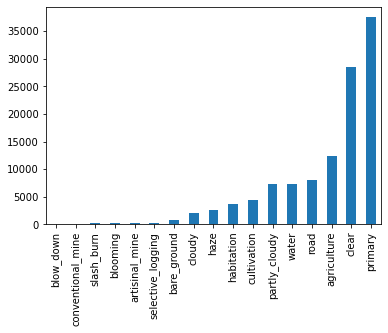

In [40]:
# Histogram of label instances

import matplotlib.pyplot as plt
%matplotlib inline

train_data[label_list].sum().sort_values().plot.bar()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


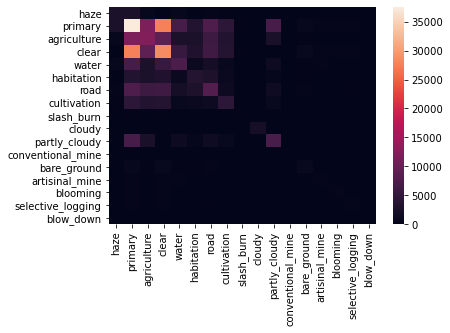

In [41]:
import seaborn as sns
def make_cooccurence_matrix(labels):
    numeric_df = train_data[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

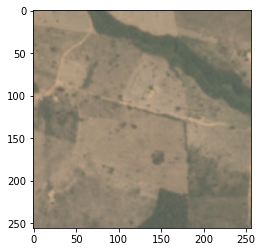

In [42]:
from matplotlib.image import imread
# load image pixels
image = imread(train_img_path+"/"+"train_10002.jpg")
	# plot raw pixel data
plt.imshow(image)
    
# show the figure
plt.show()

In [43]:
image.shape

(256, 256, 4)

In [44]:


from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed

In [45]:

def create_tag_mapping(labels_df):
    
    labels = set()
    for i in range(len(labels_df)):
        # convert spaced separated tags into an array of tags
        tags = labels_df['tags'][i].split(' ')
        # add tags to the set of known labels
        labels.update(tags)
    # convert set of labels to a list to list
    labels = list(labels)
    labels.sort()
 # dict that maps labels to integers, and the reverse
    labels_map = { labels [i]:i for i in range(len(labels))}
    inv_labels_map = {i: labels [i] for i in range(len(labels))}
    return labels_map, inv_labels_map



def create_file_mapping(train_data):
    mapping = dict()
    for i in range(len(labels_df)):
        name, tags = train_data['image_name'][i], labels_df['tags'][i]
        mapping[name] = tags.split(' ')
        
    return mapping


def one_hot_encode(tags,mapping):
    
    # create empty vector
    encoding = zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding




def load_dataset(path, file_mapping, tag_mapping):
    photos, targets = list(), list()
    # enumerate files in the directory
    for filename in listdir(folder):
        # load image
        photo = load_img(path + filename, target_size=(64,64))
        # convert to numpy array
        photo = img_to_array(photo, dtype='uint8')
        # get tags
        tags = file_mapping[filename[:-4]]
        # one hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        # store
        photos.append(photo)
        targets.append(target)
    X = asarray(photos, dtype='uint8')
    y = asarray(targets, dtype='uint8')
    return X, y
 
    
    
 

    

In [47]:
filename = '../input/planets-dataset/planet/planet/train_classes.csv'
labels_df = pd.read_csv(filename, encoding='latin1')

# create a mapping of tags to integers
mapping, inv_mapping = create_tag_mapping(labels_df)
print(len(mapping))
print(mapping)

# create a mapping of tags to integers
tag_mapping, _ = create_tag_mapping(labels_df)

# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(labels_df)

# load the jpeg images
folder = '../input/planets-dataset/planet/planet/train-jpg/'
X, y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)

# save both arrays to one file in compressed format
savez_compressed('planet_data.npz', X, y)

17
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
(40479, 64, 64, 3) (40479, 17)


In [48]:
import numpy as np
import keras 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,BatchNormalization,SpatialDropout2D
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.optimizers import SGD

In [49]:
data = np.load('./planet_data.npz')
X,y =data['arr_0'],data['arr_1']
X

array([[[[ 70,  90,  68],
         [ 77,  91,  72],
         [ 73,  90,  74],
         ...,
         [ 42,  56,  48],
         [ 50,  63,  54],
         [ 47,  66,  56]],

        [[ 74,  88,  73],
         [ 75,  89,  72],
         [ 74,  89,  70],
         ...,
         [ 33,  51,  49],
         [ 49,  66,  55],
         [ 41,  60,  50]],

        [[ 75,  90,  73],
         [ 75,  90,  73],
         [ 75,  91,  73],
         ...,
         [ 42,  59,  51],
         [ 46,  61,  53],
         [ 41,  64,  52]],

        ...,

        [[159, 139, 114],
         [155, 136, 113],
         [145, 130, 105],
         ...,
         [ 76,  93,  75],
         [ 75,  92,  72],
         [ 80,  92,  76]],

        [[157, 139, 118],
         [152, 134, 114],
         [134, 123,  99],
         ...,
         [ 80,  91,  73],
         [ 77,  90,  71],
         [ 84,  90,  75]],

        [[153, 139, 115],
         [159, 140, 118],
         [146, 131, 105],
         ...,
         [ 83,  95,  79],
        

In [50]:
from keras import backend


def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [51]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_datagen = ImageDataGenerator(featurewise_center=True)

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

train_datagen.mean = [123.68, 116.779, 103.939]
test_datagen.mean = [123.68, 116.779, 103.939]
train_datagen.fit(X_train)
test_datagen.fit(X_test)

train_it = train_datagen.flow(X_train, Y_train, batch_size=128)

test_it = test_datagen.flow(X_test, Y_test, batch_size=128)

(28335, 64, 64, 3) (28335, 17) (12144, 64, 64, 3) (12144, 17)


In [59]:
def build_model():
    in_shape=(64, 64, 3)
    out_shape=17

    # load mannequin

    mannequin = VGG16(include_top=False, input_shape=in_shape)

    # mark loaded layers as not trainable

    for layer in mannequin.layers:
        layer.trainable = False

    # enable final vgg block to be trainable

    mannequin.get_layer("block5_conv1").trainable = True

    mannequin.get_layer("block5_conv2").trainable = True

    mannequin.get_layer("block5_conv3").trainable = True

    mannequin.get_layer("block5_pool").trainable = True

    # add new classifier layers

    flat1 = Flatten()(mannequin.layers[-1].output)

    class1 = Dense(128, activation="relu", kernel_initializer="he_uniform")(flat1)

    output = Dense(out_shape, activation="sigmoid")(class1)

    # outline new mannequin

    mannequin = Model(inputs=mannequin.inputs, outputs=output)

    # compile mannequin

    choose = SGD(lr=0.01, momentum=0.9)

    mannequin.compile(optimizer=choose, loss="binary_crossentropy", metrics=[fbeta])
    
    return mannequin

In [55]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
# cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
save_best_check_point = ModelCheckpoint(filepath='our_model.hdf5', monitor='val_fbeta', mode='max', save_best_only=True, save_weights_only=True)
# checkpoint = ModelCheckpoint(filepath='weights/weights.hdf5',monitor='val_fbeta', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_fbeta', min_delta=0, patience=20, verbose=1, mode='auto')

# fit model
# history = full_model.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
mannequin.fit_generator(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=10,callbacks=[save_best_check_point])


# evaluate model
loss, fbeta = mannequin.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

Epoch 1/10
222/222 [==============================] - 43s 192ms/step - loss: 0.1183 - fbeta: 0.8621 - val_loss: 0.1221 - val_fbeta: 0.8559
Epoch 2/10
222/222 [==============================] - 42s 190ms/step - loss: 0.1158 - fbeta: 0.8654 - val_loss: 0.1285 - val_fbeta: 0.8524
Epoch 3/10
222/222 [==============================] - 42s 188ms/step - loss: 0.1146 - fbeta: 0.8670 - val_loss: 0.1275 - val_fbeta: 0.8489
Epoch 4/10
222/222 [==============================] - 43s 192ms/step - loss: 0.1126 - fbeta: 0.8696 - val_loss: 0.1243 - val_fbeta: 0.8500
Epoch 5/10
222/222 [==============================] - 43s 195ms/step - loss: 0.1118 - fbeta: 0.8688 - val_loss: 0.1184 - val_fbeta: 0.8600
Epoch 6/10
222/222 [==============================] - 42s 188ms/step - loss: 0.1104 - fbeta: 0.8709 - val_loss: 0.1196 - val_fbeta: 0.8535
Epoch 7/10
222/222 [==============================] - 43s 192ms/step - loss: 0.1097 - fbeta: 0.8732 - val_loss: 0.1196 - val_fbeta: 0.8617
Epoch 8/10
222/222 [=======

In [57]:
# plt.figure(1, figsize = (8,8)) 
# plt.subplot(211)
# plt.title('Cross Entropy Loss')
# plt.plot(history.history['loss'], color='blue', label='train')
# plt.plot(history.history['val_loss'], color='orange', label='test')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid']) 

# # plot accuracy
# plt.subplot(212)
# plt.title('Fbeta')
# plt.plot(history.history['fbeta'], color='blue', label='train')
# plt.plot(history.history['val_fbeta'], color='orange', label='test')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'valid'])


In [58]:
! ls ./

__notebook_source__.ipynb  best_model.hdf5  our_model.hdf5  planet_data.npz


In [60]:
model2 = build_model() # building a sequential model for testing

#loading in the weights of the trained model
model2.load_weights('best_model.hdf5')

In [61]:
sample_submission = sample_submission_df.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [63]:
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()
test1_df.shape
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, directory='../input/planets-dataset/planet/planet/test-jpg/', x_col='image_name', y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(64,64))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [64]:
test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
pred1 = model2.predict(test_gen1, steps=step_test_size1, verbose=1)

318/318 [==============================] - 127s 398ms/step


In [65]:
test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable

# converting the predictions of the first 40669 to tag names
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [66]:
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [73]:
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the remaining images in the sample submission dataframe
test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name', \
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(64,64))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

Found 20522 validated image filenames.


In [74]:
test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
pred2 = model2.predict(test_gen2, steps=step_test_size2, verbose=1)

161/161 [==============================] - 52s 323ms/step


In [76]:
test_file_names2 = test_gen2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable

# converting the predictions of the remaining images to tag names
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the remaining to a dataframe

len(test_file_names2)
len(pred_tags2)
result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': pred_tags2})
result2.head()


,image_name,tags
0,file_0.jpg,clear primary
1,file_1.jpg,partly_cloudy agriculture primary
2,file_10.jpg,haze primary water
3,file_100.jpg,clear agriculture primary water
4,file_1000.jpg,clear primary


In [77]:
final_result = pd.concat([result1, result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe

final_result = final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [78]:
assert sum(sample_submission['image_name'] == final_result['image_name']) == 61191

In [79]:
# removing the .jpg extension from 'iamge_name' column
final_result['image_name'] = final_result['image_name'].apply(lambda x: x[:-4])
final_result.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,partly_cloudy primary


In [80]:
final_result.to_csv('final_submission.csv', index=False) # saving the predictions